In [2]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

from collections import defaultdict
from tqdm import *

data_dir = '/mnt/data/cdiscount/'

from subprocess import check_output
print(check_output(["ls", data_dir]).decode("utf8"))

# Any results you write to the current directory are saved as output.

category_names.csv
sample_submission.csv
test.bson
train_block_0.bson
train_block_10.bson
train_block_11.bson
train_block_12.bson
train_block_13.bson
train_block_14.bson
train_block_15.bson
train_block_16.bson
train_block_17.bson
train_block_18.bson
train_block_19.bson
train_block_1.bson
train_block_20.bson
train_block_21.bson
train_block_22.bson
train_block_23.bson
train_block_24.bson
train_block_2.bson
train_block_3.bson
train_block_4.bson
train_block_5.bson
train_block_6.bson
train_block_7.bson
train_block_8.bson
train_block_9.bson
train.bson
train_example.bson



In [3]:
train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768172

categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

#categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [4]:
print('number of categories = %d' % len(categories_df["category_idx"]))
print('number of category_level1 = %d' % len(categories_df["category_level1"].unique()))
print('number of category_level2 = %d' % len(categories_df["category_level2"].unique()))
print('number of category_level3 = %d' % len(categories_df["category_level3"].unique()))

number of categories = 5270
number of category_level1 = 49
number of category_level2 = 483
number of category_level3 = 5263


In [5]:
category_count = categories_df["category_level1"].value_counts()
print(category_count)

SPORT                                         555
BRICOLAGE - OUTILLAGE - QUINCAILLERIE         441
AUTO - MOTO                                   440
ART DE LA TABLE - ARTICLES CULINAIRES         237
JEUX - JOUETS                                 230
JARDIN - PISCINE                              230
LOISIRS CREATIFS - BEAUX ARTS - PAPETERIE     220
DECO - LINGE - LUMINAIRE                      206
ELECTROMENAGER                                196
HYGIENE - BEAUTE - PARFUM                     184
PUERICULTURE                                  180
LIBRAIRIE                                     162
ANIMALERIE                                    158
INFORMATIQUE                                  137
MEUBLE                                        106
MATERIEL MEDICAL                              104
PHOTO - OPTIQUE                               103
EPICERIE                                      101
PARAPHARMACIE                                  99
TV - VIDEO - SON                               89


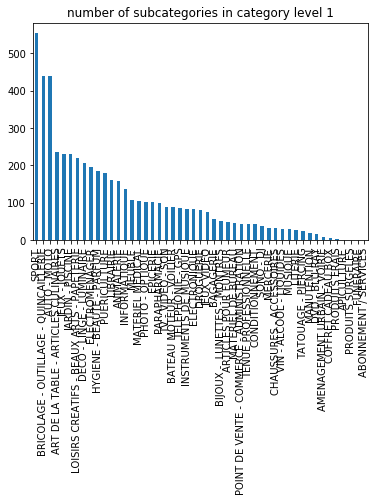

In [6]:
category_count.plot(kind='bar', title="number of subcategories in category level 1")

In [7]:
for category_level1 in categories_df["category_level1"].unique():
    print(category_level1)
    categories_level_df = categories_df.loc[categories_df["category_level1"] == category_level1]
    print(categories_level_df["category_level2"].value_counts())


ABONNEMENT / SERVICES
CARTE PREPAYEE    1
Name: category_level2, dtype: int64
AMENAGEMENT URBAIN - VOIRIE
SIGNALISATION ROUTIERE    3
AMENAGEMENT URBAIN        3
VOIRIE                    2
SIGNALETIQUE              1
Name: category_level2, dtype: int64
ANIMALERIE
HABITAT - COUCHAGE                     18
VETEMENT - ACCESSOIRE                  18
MATERIEL DE TOILETTAGE                 13
ALIMENTATION                           13
JOUET                                  12
HYGIENE LITIERE DEJECTIONS             12
ACCESSOIRE POUR REPAS                  11
PRODUIT DE SOIN - HYGIENE              11
ATTACHE - SELLERIE                     11
EDUCATION - ACTIVITE                    9
AMENAGEMENT TECHNIQUE DE L'HABITAT      8
SECURITE - PROTECTION                   7
TRANSPORT - DEPLACEMENT - PROMENADE     7
DECORATION DE L'HABITAT                 4
MATERNAGE - ELEVAGE                     4
Name: category_level2, dtype: int64
APICULTURE
OUTILS DE L'APICULTEUR    1
Name: category_level2, dtype: 

In [8]:
train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)

/home/weiso/tensorflow/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [10]:
print('number of products = %d' % len(train_offsets_df))
print('number of catagories = %d' % len(train_offsets_df["category_id"].unique()))
print('number of images = %d' % train_offsets_df["num_imgs"].sum())

number of products = 7069896
number of catagories = 5270
number of images = 12371293


In [11]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

In [15]:
total_images_df = pd.read_csv('total_images.csv', index_col=0)
total_images_df.head()

/home/weiso/tensorflow/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,product_id,category_idx,img_idx
0,36254,619,0
1,42537,619,0
2,55264,619,0
3,104035,619,0
4,114584,619,0


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

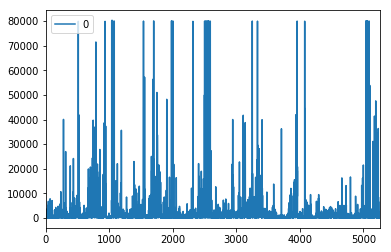

In [16]:
num_images_per_cat = []
for category_idx in range(len(categories_df)):
    num_images = np.sum(total_images_df["category_idx"] == category_idx)
    num_images_per_cat.append(num_images)

num_images_per_cat_df = pd.DataFrame(num_images_per_cat)
num_images_per_cat_df.plot()

In [24]:
num_images_per_cat_df.head()

,count,category_id
0,32,0
1,1999,1
2,44,2
3,56,3
4,341,4


In [25]:
#num_images_per_cat_df['category_id'] = num_images_per_cat_df.index
num_images_per_cat_df['category_id'] = num_images_per_cat_df['category_id'].apply(lambda x: idx2cat[x])
num_images_per_cat_df.head()

,count,category_id
0,32,1000021794
1,1999,1000012764
2,44,1000012776
3,56,1000012768
4,341,1000012755


In [31]:
num_images_per_cat_df = num_images_per_cat_df.sort_values("count", ascending=False)
num_images_per_cat_df.head()

,count,category_id
1046,80348,1000010110
5051,80112,1000010647
1982,80103,1000003796
1702,80086,1000012965
2560,80069,1000011423


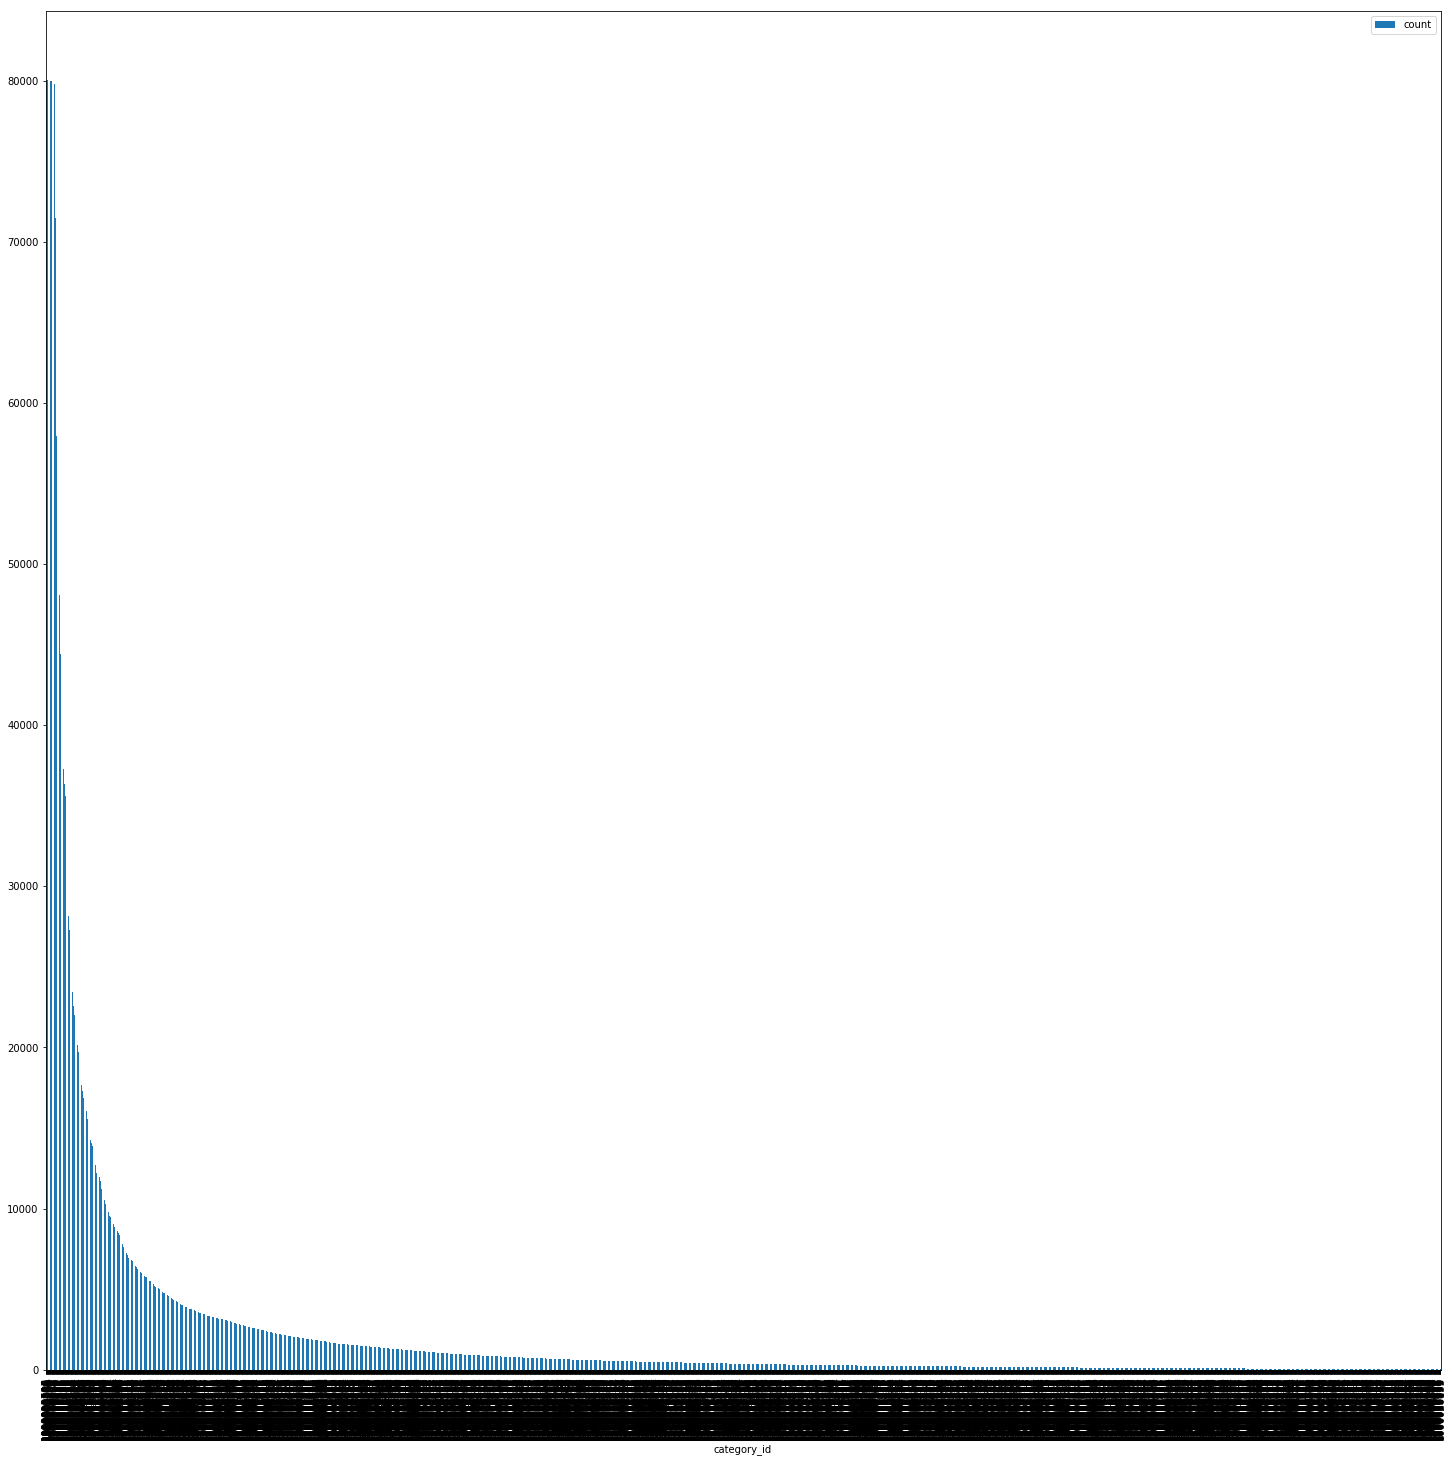

In [37]:
num_images_per_cat_df.plot(x='category_id', y='count', kind='bar', figsize=(25, 25))